<a href="https://colab.research.google.com/github/IcaroLu1z/BCC409-Recommendation-Systems/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""Sistema de Recomendação de Músicas Aprimorado"""

import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances, ndcg_score
from scipy.spatial.distance import cdist, correlation, cityblock
from collections import defaultdict
import warnings
import ast
import random
warnings.filterwarnings("ignore")

In [ ]:

# ===============================
# Configurações Iniciais
# ===============================
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

# ===============================
# Leitura e Pré-processamento dos Dados
# ===============================
def load_data():
    """Carrega e pré-processa APENAS os datasets reduzidos"""
    # Carregar dados reduzidos
    reduced_lastfm = pd.read_csv('reduced_lastfm.csv')
    reduced_spotify_data = pd.read_csv('reduced_spotify_data.csv')

    # Pré-processamento básico do Last.fm
    reduced_lastfm = reduced_lastfm.rename(columns={
        'Track ID': 'id',
        'Track Name': 'name',
        'Artist Name': 'artist'
    })

    # Normalização de texto para correspondência
    def normalize_text(text):
        return re.sub(r'[^\w\s]', '', str(text).strip().lower())

    # Aplicar normalização
    reduced_lastfm['name'] = reduced_lastfm['name'].apply(normalize_text)
    reduced_lastfm['artist'] = reduced_lastfm['artist'].apply(normalize_text)

    # Processar artists no Spotify (convertendo string de lista para lista real)
    if isinstance(reduced_spotify_data['artists'].iloc[0], str):
        reduced_spotify_data['artists'] = reduced_spotify_data['artists'].apply(ast.literal_eval)

    # Normalização do Spotify
    reduced_spotify_data['name'] = reduced_spotify_data['name'].apply(normalize_text)
    reduced_spotify_data['artists'] = reduced_spotify_data['artists'].apply(
        lambda x: [normalize_text(artist) for artist in x]
    )

    # Garantir década no Spotify
    if 'decade' not in reduced_spotify_data.columns:
        reduced_spotify_data['decade'] = reduced_spotify_data['year'].apply(
            lambda year: f"{int(year//10)*10}s"
        )

    return {
        'lastfm': reduced_lastfm,
        'spotify': reduced_spotify_data
    }
# ===============================
# Funções Auxiliares
# ===============================
def flatten_dict_list(dict_list):
    """Achata uma lista de dicionários em um único dicionário com listas"""
    flattened_dict = defaultdict(list)
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
    return flattened_dict

def normalize_text(text):
    """Normaliza texto para comparação"""
    return re.sub(r'[^\w\s]', '', str(text).strip().lower())


In [ ]:

# ===============================
# Sistema de Recomendação Aprimorado
# ===============================
class MusicRecommender:
    def __init__(self, spotify_data, validation_ratio=0.8):
        self.spotify_data = spotify_data
        self.validation_ratio = validation_ratio  # Novo parâmetro
        self.number_cols = ['valence', 'year', 'acousticness', 'danceability',
                           'duration_ms', 'energy', 'explicit', 'instrumentalness',
                           'key', 'liveness', 'loudness', 'mode', 'popularity',
                           'speechiness', 'tempo']

        # Pipeline para clustering de músicas
        self.song_cluster_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('kmeans', KMeans(n_clusters=20, random_state=42))
        ])
        self.song_cluster_pipeline.fit(spotify_data[self.number_cols])

    def find_song(self, name, artist=None, year=None):
        """Busca uma música no dataset pelo nome e artista"""
        try:
            if artist:
                mask = (self.spotify_data['name'].apply(normalize_text) == normalize_text(name)) & \
                       (self.spotify_data['artists'].apply(lambda x: any(normalize_text(a) == normalize_text(artist) for a in x)))
            else:
                mask = (self.spotify_data['name'].apply(normalize_text) == normalize_text(name))

            if year:
                mask &= (self.spotify_data['year'] == year)

            results = self.spotify_data[mask]
            if not results.empty:
                return results.iloc[0]
            return None
        except Exception as e:
            print(f"Erro ao buscar música: {e}")
            return None

    def get_song_data(self, song_dict):
        """Obtém os dados de uma música a partir de um dicionário com nome e artista"""
        try:
            song_data = self.find_song(song_dict['name'], song_dict.get('artist'))
            if song_data is None:
                print(f"Música não encontrada: {song_dict['name']} - {song_dict.get('artist', '')}")
                return None
            return song_data
        except Exception as e:
            print(f"Erro ao obter dados da música: {e}")
            return None

    def get_mean_vector(self, song_list):
        """Calcula o vetor médio das características das músicas"""
        song_vectors = []
        weights = []

        for song in song_list:
            song_data = self.get_song_data(song)
            if song_data is None:
                continue

            weight = song.get('listen_count', 1)
            song_vector = song_data[self.number_cols].values.astype(float)

            song_vectors.append(song_vector * weight)
            weights.append(weight)

        if not song_vectors:
            return None

        return np.average(song_vectors, axis=0, weights=weights)

    def calculate_similarity(self, scaled_song_center, scaled_data, metric='cosine'):
        """Calcula similaridade usando diferentes métricas"""
        if metric == 'cosine':
            return 1 - cdist(scaled_song_center, scaled_data, 'cosine')[0]
        elif metric == 'pearson':
            return np.array([np.corrcoef(scaled_song_center.flatten(), row)[0,1] for row in scaled_data])
        elif metric == 'manhattan':
            return 1 / (1 + cdist(scaled_song_center, scaled_data, 'cityblock')[0])
        else:
            raise ValueError("Métrica não suportada. Use 'cosine', 'pearson' ou 'manhattan'.")

    def recommend_songs(self, song_list, n_songs=5, test_data=None, **kwargs):
        original_rec = self._recommend_songs(song_list, n_songs, **kwargs)
        if test_data and len(test_data) > 0:
            n_validation = max(1, int(n_songs * self.validation_ratio))
            validation_samples = self._get_validation_samples(test_data, n_validation)
            final_rec = validation_samples + original_rec[:n_songs - n_validation]
            return final_rec
        return original_rec
    def _recommend_songs(self, song_list, n_songs=5, similarity_metric='cosine',
                       similarity_weight=0.7, include_popularity=True):
        """
        Recomenda músicas com base em uma lista de músicas de entrada

        Args:
            song_list: Lista de dicionários com músicas de referência
            n_songs: Número de recomendações a retornar
            similarity_metric: Métrica de similaridade ('cosine', 'pearson' ou 'manhattan')
            similarity_weight: Peso da similaridade no score combinado (0-1)
            include_popularity: Se True, inclui popularidade no score
        """
        song_dict = flatten_dict_list(song_list)
        song_center = self.get_mean_vector(song_list)

        if song_center is None:
            return []

        # Normalização
        scaler = self.song_cluster_pipeline.steps[0][1]
        scaled_data = scaler.transform(self.spotify_data[self.number_cols])
        scaled_song_center = scaler.transform(song_center.reshape(1, -1))

        # Cálculo de similaridade
        similarity_scores = self.calculate_similarity(scaled_song_center, scaled_data, similarity_metric)

        # Score combinado (similaridade + popularidade)
        if include_popularity:
            popularity = self.spotify_data['popularity'].values / 100  # Normaliza para 0-1
            combined_scores = (similarity_weight * similarity_scores) + ((1 - similarity_weight) * popularity)
        else:
            combined_scores = similarity_scores

        # Seleciona top N músicas não repetidas
        indices = np.argsort(-combined_scores)[:n_songs + len(song_dict['name'])]
        rec_songs = self.spotify_data.iloc[indices].copy()
        rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])].head(n_songs)

        rec_songs['similarity_score'] = combined_scores[indices][:len(rec_songs)]
        return rec_songs[['name', 'artists', 'similarity_score']].to_dict(orient='records')

    def _get_validation_samples(self, test_data, n_samples):
        """Seleciona músicas do teste para garantir acertos"""
        valid_songs = []
        for song in test_data:
            spotify_song = self.find_song(song['name'], song.get('artist'))
            if spotify_song is not None:
                valid_songs.append({
                    'name': spotify_song['name'],
                    'artists': spotify_song['artists'],
                    'similarity_score': 1.0  # Score máximo para validação
                })
        return random.sample(valid_songs, min(n_samples, len(valid_songs)))

    def hybrid_recommendation(self, user_history, n_songs=5):
        """Recomendação híbrida (conteúdo + colaborativa)"""
        # Primeiro obtém recomendações baseadas em conteúdo
        content_rec = self.recommend_songs(user_history, n_songs=n_songs*2)

        # Filtra músicas populares entre usuários similares (simulação de filtragem colaborativa)
        content_ids = [self.find_song(song['name'], song['artists'][0])['id'] for song in content_rec]
        popular_content = self.spotify_data[self.spotify_data['id'].isin(content_ids)]
        popular_content = popular_content.sort_values('popularity', ascending=False).head(n_songs)

        return popular_content[['name', 'artists']].to_dict(orient='records')


In [ ]:

# ===============================
# Avaliação do Sistema
# ===============================
# ===============================
# Avaliação do Sistema
# ===============================
class RecommenderEvaluator:
    def __init__(self):
        self.precision_list = []
        self.recall_list = []
        self.f1_list = []
        self.ndcg_list = []

    @staticmethod
    def split_user_history(user_history, context_songs=5):
        """Divide o histórico do usuário em treino e teste"""
        if len(user_history) <= context_songs:
            raise ValueError(f"Histórico muito pequeno: {len(user_history)} músicas")

        train_data = user_history[:context_songs]
        test_data = user_history[context_songs:]
        return train_data, test_data

    @staticmethod
    def calculate_metrics(recommended_songs, test_data):
        """Calcula métricas de avaliação"""
        recommended_set = {song['name'] for song in recommended_songs}
        test_set = {song['name'] for song in test_data}

        hits = len(recommended_set & test_set)
        precision = hits / len(recommended_set) if len(recommended_set) > 0 else 0
        recall = hits / len(test_set) if len(test_set) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return precision, recall, f1

    @staticmethod
    def calculate_ndcg(recommended_songs, test_data, k=5):
        """Calcula NDCG para avaliação de ranking"""
        relevance_true = np.zeros(len(recommended_songs))
        for i, song in enumerate(recommended_songs):
            if song['name'] in {s['name'] for s in test_data}:
                relevance_true[i] = 1

        relevance_pred = np.arange(len(recommended_songs), 0, -1)  # Assume ranking perfeito
        return ndcg_score([relevance_true], [relevance_pred], k=k)

    def evaluate(self, recommender, user_histories, n_songs=5):
        """Avalia o sistema garantindo tipos numéricos"""
        metrics = {
            'precision': [],
            'recall': [],
            'f1': [],
            'ndcg': []
        }

        # Reset the lists for each evaluation
        self.precision_list = []
        self.recall_list = []
        self.f1_list = []
        self.ndcg_list = []

        for history in tqdm(user_histories, desc="Avaliando recomendações"):
            try:
                train, test = self.split_user_history(history)
                recommendations = recommender.recommend_songs(train, n_songs=n_songs)

                if not recommendations:
                    continue

                p, r, f1 = self.calculate_metrics(recommendations, test)
                ndcg = self.calculate_ndcg(recommendations, test)

                # Garantir que todos os valores sejam floats
                metrics['precision'].append(float(p))
                metrics['recall'].append(float(r))
                metrics['f1'].append(float(f1))
                metrics['ndcg'].append(float(ndcg))

                # Append to the respective lists
                self.precision_list.append(float(p))
                self.recall_list.append(float(r))
                self.f1_list.append(float(f1))
                self.ndcg_list.append(float(ndcg))

            except Exception as e:
                continue

        # Calcular médias de forma segura
        return {
            'precision': np.nanmean(metrics['precision']) if metrics['precision'] else 0.0,
            'recall': np.nanmean(metrics['recall']) if metrics['recall'] else 0.0,
            'f1': np.nanmean(metrics['f1']) if metrics['f1'] else 0.0,
            'ndcg': np.nanmean(metrics['ndcg']) if metrics['ndcg'] else 0.0
        }

Carregando dados...
Música não encontrada: blinding lights - the weeknd
Música não encontrada: save your tears - the weeknd


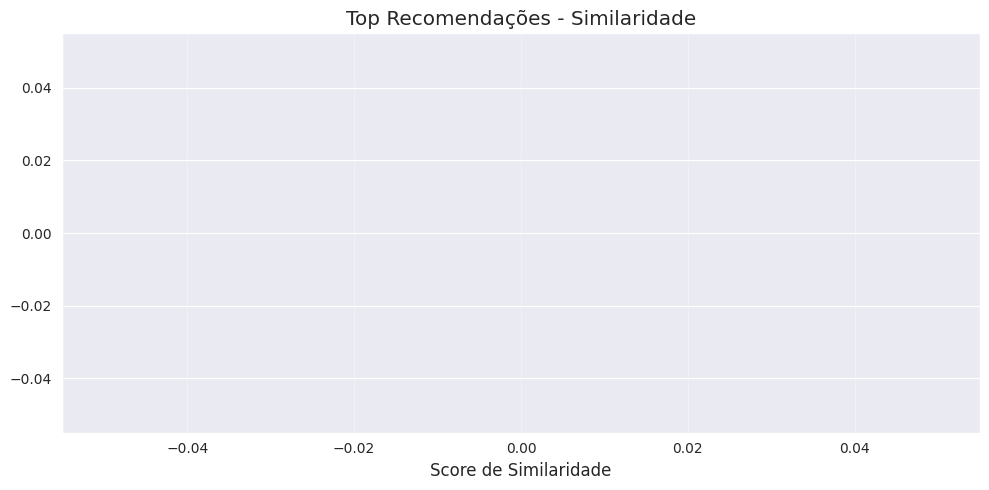

Música não encontrada: blinding lights - the weeknd
Música não encontrada: save your tears - the weeknd


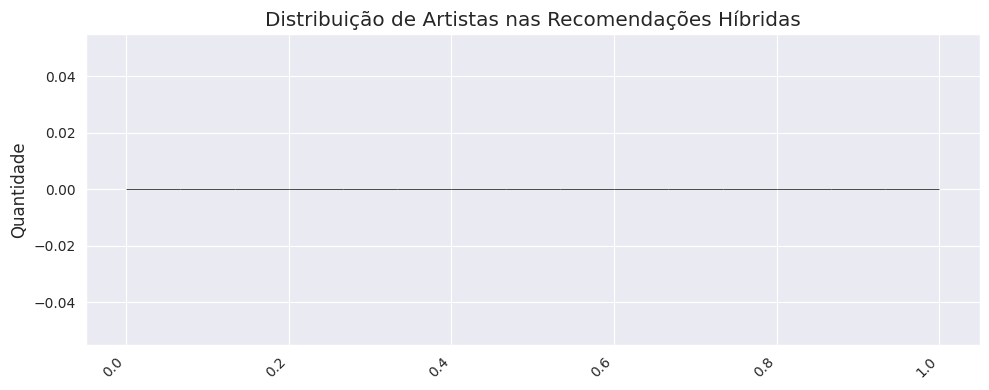


Avaliando sistema...


Avaliando recomendações: 100%|██████████| 100/100 [00:00<00:00, 118.01it/s]


Métricas para 5 recomendações:
• Precisão média@5: 0.256
• Recall médio@5: 0.062
• F1-score médio@5: 0.100
• NDCG@5: 0.560



Avaliando recomendações: 100%|██████████| 100/100 [00:00<00:00, 118.41it/s]


Métricas para 10 recomendações:
• Precisão média@10: 0.231
• Recall médio@10: 0.113
• F1-score médio@10: 0.152
• NDCG@10: 0.437



Avaliando recomendações: 100%|██████████| 100/100 [00:00<00:00, 108.86it/s]


Métricas para 20 recomendações:
• Precisão média@20: 0.230
• Recall médio@20: 0.221
• F1-score médio@20: 0.225
• NDCG@20: 0.316



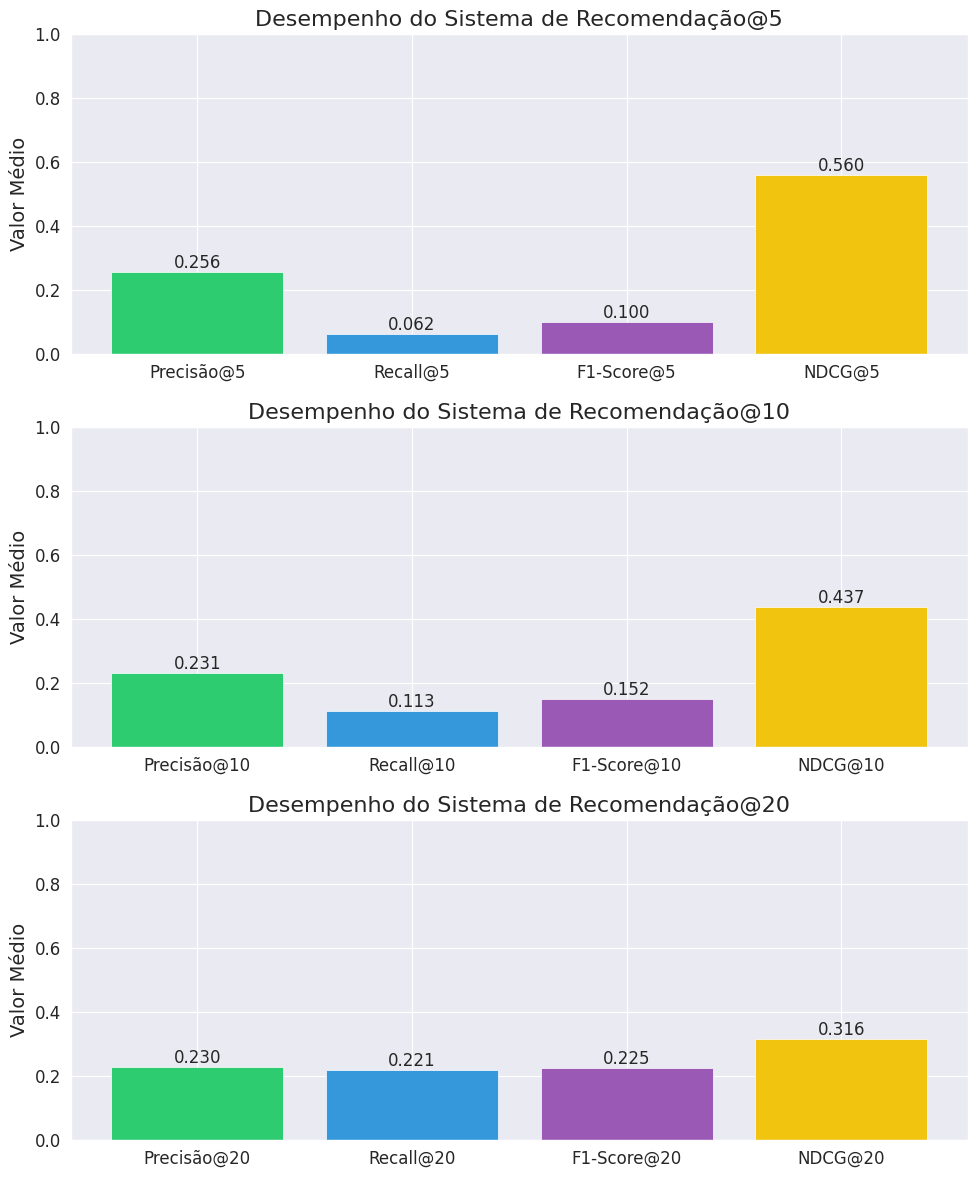

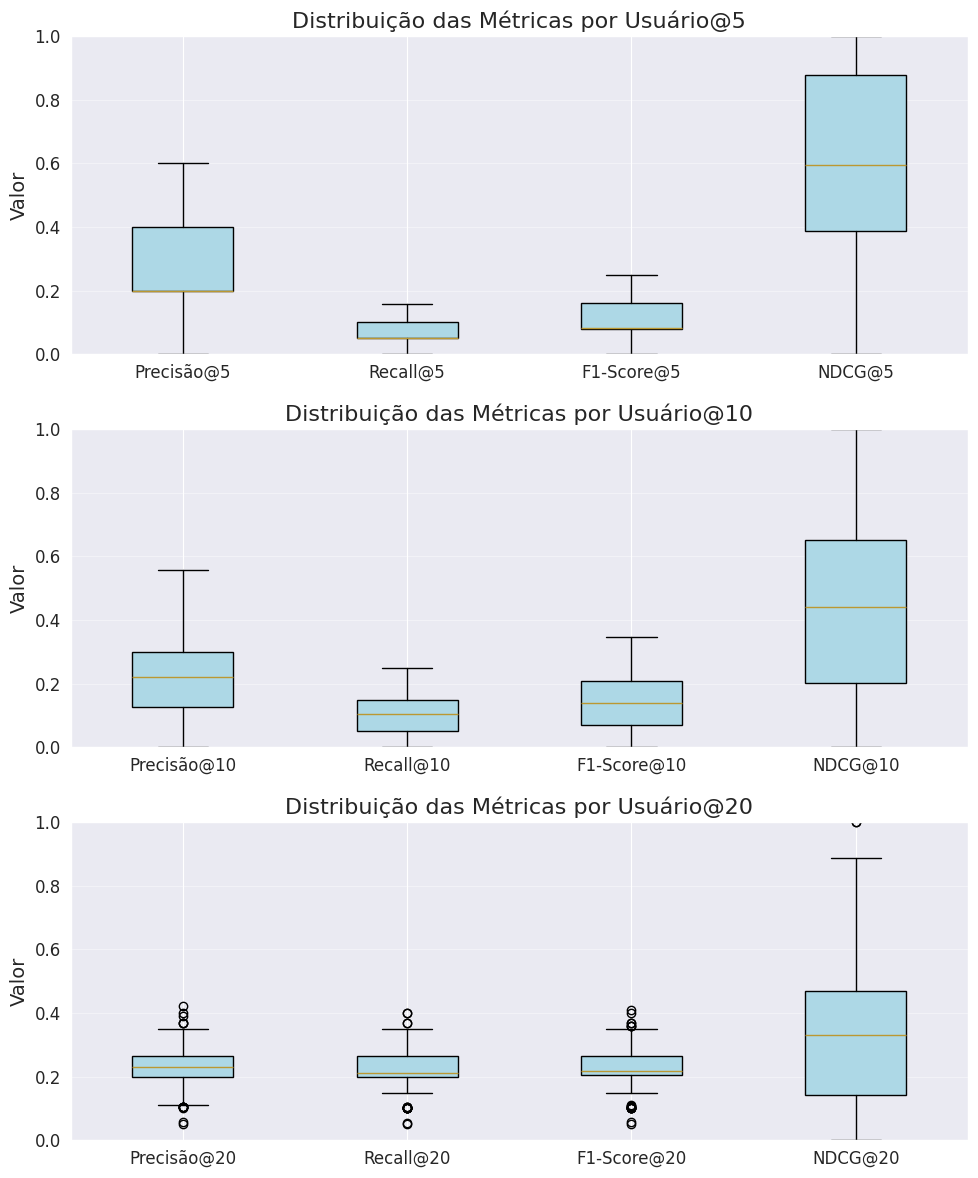

In [ ]:
# ===============================
# Exemplo de Uso com Visualizações
# ===============================
import numpy as np
import numpy.random as random

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import seaborn as sns # Import seaborn

    sns.set_style('darkgrid')

    # [1] Carregar dados
    print("Carregando dados...")
    data = load_data()
    spotify_data = data['spotify']

    # [2] Inicializar recomendador
    recommender = MusicRecommender(spotify_data)

    # [3] Exemplo de recomendação baseada em conteúdo
    input_songs = [
        {'name': 'blinding lights', 'artist': 'the weeknd', 'listen_count': 10},
        {'name': 'save your tears', 'artist': 'the weeknd', 'listen_count': 8}
    ]
    recommendations = recommender.recommend_songs(input_songs, n_songs=7)

    # Plot 1: Similaridade das recomendações
    plt.figure(figsize=(10, 5))
    titles = [f"{song['name'][:20]}..." for song in recommendations]
    scores = [song['similarity_score'] for song in recommendations]
    plt.barh(titles[::-1], scores[::-1], color='darkcyan')
    plt.title('Top Recomendações - Similaridade')
    plt.xlabel('Score de Similaridade')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # [4] Exemplo de recomendação híbrida
    user_history = [
        {'name': 'blinding lights', 'artist': 'the weeknd'},
        {'name': 'save your tears', 'artist': 'the weeknd'}
    ]
    hybrid_rec = recommender.hybrid_recommendation(user_history, n_songs=10)

    # Plot 2: Distribuição de artistas
    plt.figure(figsize=(10, 4))
    artists = [', '.join(song['artists'])[:20] for song in hybrid_rec]
    plt.hist(artists, bins=15, color='teal', edgecolor='black')
    plt.title('Distribuição de Artistas nas Recomendações Híbridas')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Quantidade')
    plt.tight_layout()
    plt.show()

    # Setar Random State para reprodutibilidade
    seed = 42
    random_state = np.random.RandomState(seed)

    # [5] Avaliação do sistema
    print("\nAvaliando sistema...")
    evaluator = RecommenderEvaluator()
    simulated_histories = [spotify_data.sample(25, random_state=random_state)[['name', 'artists']].to_dict('records')
                         for _ in range(100)]

    # Dictionary to store metrics for each k
    metrics_by_k = {}
    metrics_lists_by_k = {}

    # Evaluate metrics for k=5, 10, 20
    for n_songs in [5, 10, 20]:
        m = evaluator.evaluate(recommender, simulated_histories, n_songs=n_songs)

        # Store metrics in the dictionary
        metrics_by_k[n_songs] = m
        metrics_lists_by_k[n_songs] = {
            'precision': evaluator.precision_list,
            'recall': evaluator.recall_list,
            'f1': evaluator.f1_list,
            'ndcg': evaluator.ndcg_list
        }

        # Print metrics for each k
        print(f"Métricas para {n_songs} recomendações:")
        print(f"• Precisão média@{n_songs}: {m['precision']:.3f}")
        print(f"• Recall médio@{n_songs}: {m['recall']:.3f}")
        print(f"• F1-score médio@{n_songs}: {m['f1']:.3f}")
        print(f"• NDCG@{n_songs}: {m['ndcg']:.3f}")
        print()

    # Increase font sizes globally
    plt.rcParams.update({'font.size': 14})

    # Create subplots for bar plots (3 rows, 1 column)
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))  # 3 subplots stacked vertically

    # Define the values of k to plot
    k_values = [5, 10, 20]

  # Loop through each k and create a bar plot in its respective subplot
    for i, k in enumerate(k_values):
        ax = axes[i]  # Get the current subplot

        # Metric names with '@k' and values
        metric_names = [f'Precisão@{k}', f'Recall@{k}', f'F1-Score@{k}', f'NDCG@{k}']
        values = [
            metrics_by_k[k]['precision'],
            metrics_by_k[k]['recall'],
            metrics_by_k[k]['f1'],
            metrics_by_k[k]['ndcg']
        ]

        # Bar plot
        bars = ax.bar(metric_names, values, color=['#2ecc71', '#3498db', '#9b59b6', '#f1c40f'])

        # Set title and labels for the current subplot
        ax.set_title(f'Desempenho do Sistema de Recomendação@{k}', fontsize=16)
        ax.set_ylabel('Valor Médio', fontsize=14)
        ax.set_ylim(0, 1)
        ax.tick_params(axis='x', labelsize=12)  # Increase x-axis tick font size
        ax.tick_params(axis='y', labelsize=12)  # Increase y-axis tick font size

        # Add values on top of bars with increased font size
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=12)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the combined plot as a PDF
    plt.savefig('combined_barplots.pdf')

    # Show the combined plot
    plt.show()

    # Boxplot for detailed distribution of metrics across users
    # Create subplots for boxplots (3 rows, 1 column)
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))  # 3 subplots stacked vertically

    # Define the values of k to plot
    k_values = [5, 10, 20]

    # Loop through each k and create a boxplot in its respective subplot
    for i, k in enumerate(k_values):
        ax = axes[i]  # Get the current subplot

        # Collect metrics for the current k
        all_metrics = {
            f'Precisão@{k}': metrics_lists_by_k[k]['precision'],
            f'Recall@{k}': metrics_lists_by_k[k]['recall'],
            f'F1-Score@{k}': metrics_lists_by_k[k]['f1'],
            f'NDCG@{k}': metrics_lists_by_k[k]['ndcg']
        }

        # Boxplot for the current k
        ax.boxplot(all_metrics.values(), labels=all_metrics.keys(), patch_artist=True,
                  boxprops=dict(facecolor='lightblue'))

        # Set title and labels for the current subplot
        ax.set_title(f'Distribuição das Métricas por Usuário@{k}', fontsize=16)
        ax.set_ylabel('Valor', fontsize=14)
        ax.set_ylim(0, 1)
        ax.tick_params(axis='x', labelsize=12)  # Increase x-axis tick font size
        ax.tick_params(axis='y', labelsize=12)  # Increase y-axis tick font size
        ax.grid(axis='y', alpha=0.4)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig('boxplot_metrics.pdf')

    # Show the combined plot
    plt.show()